In [49]:
# getting the list of imports
%matplotlib inline
import math

import numpy as np
from   numpy import linalg
import cvxopt
import cvxopt.solvers
import pylab as pl
import datageneration as dg
from datageneration import *

from sklearn.cross_validation import train_test_split

from sklearn import datasets, linear_model
from sklearn.cross_validation import KFold    
from sklearn import metrics
from sklearn.svm import SVC

# from pandas
import pandas as pd


from cvxopt import solvers

In [50]:
class TestMetrics:
    
    def setData(self,y_test,y_pred_class):
            self.y_test = y_test
            self.y_pred_class = y_pred_class
#             print 'True:', y_test
#             print 'Pred:', y_pred_class
        
    def getMatrics(self):
        confusion = metrics.confusion_matrix(self.y_test, self.y_pred_class)
        TP = confusion[1, 1]
        TN = confusion[0, 0]
        FP = confusion[0, 1]
        FN = confusion[1, 0]
        if math.isnan(TP):
            print "tp is nan"
            TP = 0
        if math.isnan(TN):
            print "tn is nan"
            TN = 0
        if math.isnan(FP):
            print "fp is nan"
            FP = 0
        if math.isnan(FN):
            print " is nan"
            FN = 0       

        Classification_Accuracy = metrics.accuracy_score(self.y_test, self.y_pred_class)
        Classification_Error =  1 - metrics.accuracy_score(self.y_test, self.y_pred_class)
        
        #Sensitivity:
        Sensitivity = TP / float(TP + FN)

        #Specificity: 
        Specificity = TN / float(TN + FP) 
        
        False_Positive_Rate = FP / float(TN + FP)

        #Precision: 
        Precision = metrics.precision_score(self.y_test, self.y_pred_class)
        
        return TP,TN,FP,FN,Classification_Accuracy,Classification_Error,Sensitivity,Specificity,False_Positive_Rate,Precision

In [51]:
linearKernel      = lambda x1, x2          : np.dot(x1, x2)

polynomialKernel = lambda x, y, q=5       : (1 + np.dot(x, y)) ** q

gaussian_kernel   = lambda x, y, sigma=5.0 : np.exp(-linalg.norm(x-y)**2 / (2 * (sigma ** 2)))

def getAlpha(X, y,kernel=linearKernel, C=None):
    M_Samples, N_Features = X.shape
    # this is to construct the k matrix  and multiply with the y*y.T
    K = np.zeros((M_Samples, M_Samples))
   
    for i in range(M_Samples):
        for j in range(M_Samples):
            K[i,j] = kernel(X[i], X[j])
        
    P   =   cvxopt.matrix(np.outer(y,y) * K)
    q   =   cvxopt.matrix(np.ones(M_Samples) * -1)
    A   =   cvxopt.matrix(y, (1,M_Samples))
    b   =   cvxopt.matrix(0.0)
    
    ### if the c values is provided computer the G and H matrix seperately
    if C is None:
        G   =   cvxopt.matrix(np.diag(np.ones(M_Samples) * -1))
        h   =   cvxopt.matrix(np.zeros(M_Samples))
    else:
        # this is to create the G matrix . Condition to take care of the upper triangle 
        upper_G_matrix    =    np.diag(np.ones(M_Samples) * -1)
        lower_G_matrix    =    np.identity(M_Samples)
        G                 =    cvxopt.matrix(np.vstack((upper_G_matrix, lower_G_matrix)))
        # you are create the h matrix
        upper_h_matrix    =    np.zeros(M_Samples)
        lower_h_matrix    =    np.ones(M_Samples) * C
        h                 =    cvxopt.matrix(np.hstack((upper_h_matrix, lower_h_matrix)))
    # solve QP problem
    sol = solvers.qp(P, q, G, h, A, b)
    
    #getting the list of alpha/lagrange multiplier
    a = np.ravel(sol['x'])
    ##sending the list of parameter computed
    return a,K,P,q,A,b,G,h

'''
Algorithms: for the working of SVM
1>Solve dual for alpha
2>idendity support vector set
3>compute w and w0
'''
class SVM_implementation():
    def __init__(self, kernel=linearKernel, C=None):
        self.kernel = kernel
        self.C = [float(C) if C is not None else C][0]

    def fit(self, X, y,kernel=linearKernel, C=None):
        M_Samples, N_Features = X.shape
        
        # this is to get the alpha
        a,K,P,q,A,b,G,h = getAlpha(X, y,self.kernel, self.C)
        
        # compute suppoert vector through alpha
        sv  = a > 1e-4
        indicator       = np.arange(len(a))[sv]
        self.a          = a[sv]
        
        # getting all the x and y of the support vectors
        self.sv   = X[sv]
        self.sv_y = y[sv]
       
        # calculating the intercepts
        self.b = 0 ## setting the initial b to zero 
        for n in range(len(self.a)):
            self.b = self.b + self.sv_y[n]
            self.b = self.b + np.sum(self.a * self.sv_y * K[indicator[n],sv])
        self.b = self.b /len(a)

        # computing the weight-vector
        #ie w0= 1/#sv * sum<all vector>()self.a
        if self.kernel == linearKernel:
            self.w = np.zeros(N_Features)
            for n in range(len(self.a)):
                self.w =self.w + (self.a[n] * self.sv_y[n] * self.sv[n])
        else:
            self.w = None

  
    def predict(self, X):
        if self.w is not None:
            returnVal = np.dot(X, self.w) + self.b
        else:
            y_predict = np.zeros(len(X))
            for i in range(len(X)):
                s = 0
                for a, sv_y, sv in zip(self.a, self.sv_y, self.sv):
                    s += a * sv_y * self.kernel(X[i], sv)
                y_predict[i] = s
            returnVal = y_predict + self.b
        return  np.sign(returnVal)
    
    def project(self, X):
        if self.w is not None:
            return np.dot(X, self.w) + self.b
        else:
            y_predict = np.zeros(len(X))
            for i in range(len(X)):
                s = 0
                for a, sv_y, sv in zip(self.a, self.sv_y, self.sv):
                    s += a * sv_y * self.kernel(X[i], sv)
                y_predict[i] = s
            return y_predict + self.b
        
        
        x_1 = [ a[0] for a in X1[:,:1]]
    x_2 = [ a[0] for a in X2[:,:1]]

linear seperable data


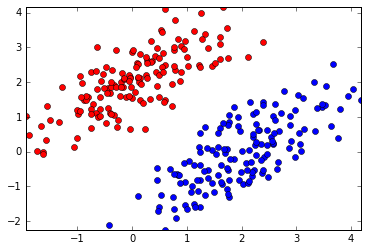

linear seperable data over lapping data


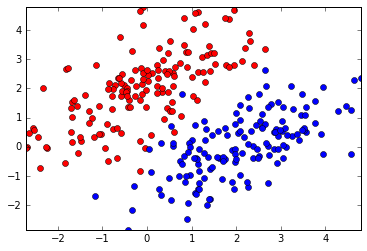

non linear seperable seperable data 


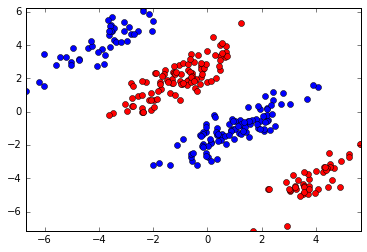

In [52]:
#Q1


def plM(X1_train, X2_train):

    pl.plot(X1_train[:,0], X1_train[:,1], "ro")
    pl.plot(X2_train[:,0], X2_train[:,1], "bo")

    pl.axis("tight")
    pl.show()
    
clf = SVC()    
print "linear seperable data"
X1, Y1, X2, Y2 = linearSeperableData()
X_train, Y_train = trainingData(X1, Y1, X2, Y2)
plM(X_train[Y_train==1], X_train[Y_train==-1])

print "linear seperable data over lapping data"
X1, Y1, X2, Y2 = linearSeperableOverLapData()
X_train, Y_train = trainingData(X1, Y1, X2, Y2)
plM(X_train[Y_train==1], X_train[Y_train==-1])


print "non linear seperable seperable data "
X1, Y1, X2, Y2 = nonLinearSeperableData()
X_train, Y_train = trainingData(X1, Y1, X2, Y2)
plM(X_train[Y_train==1], X_train[Y_train==-1])

     pcost       dcost       gap    pres   dres
 0: -5.5798e+01 -1.1675e+02  1e+03  3e+01  2e+00
 1: -1.1977e+02 -1.3798e+02  7e+02  2e+01  1e+00
 2: -3.7636e+02 -4.2291e+02  7e+02  2e+01  1e+00
 3: -1.7386e+03 -1.9082e+03  7e+02  2e+01  1e+00
 4: -1.7426e+04 -1.8509e+04  1e+03  2e+01  1e+00
 5: -2.8578e+04 -3.0290e+04  2e+03  2e+01  1e+00
 6: -3.7395e+04 -3.9597e+04  2e+03  2e+01  1e+00
 7: -1.5120e+05 -1.5863e+05  7e+03  2e+01  1e+00
 8: -6.8527e+05 -7.1337e+05  3e+04  2e+01  1e+00
 9: -1.4836e+07 -1.4949e+07  1e+05  2e+01  1e+00
10: -9.4438e+08 -9.4817e+08  4e+06  2e+01  1e+00
11: -8.6687e+10 -8.6910e+10  2e+08  2e+01  1e+00
12: -2.7233e+12 -2.7278e+12  5e+09  2e+01  1e+00
Terminated (singular KKT matrix).


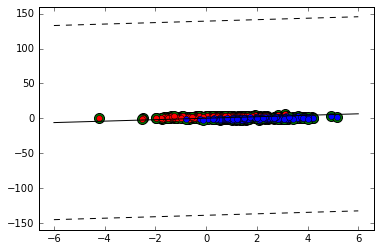

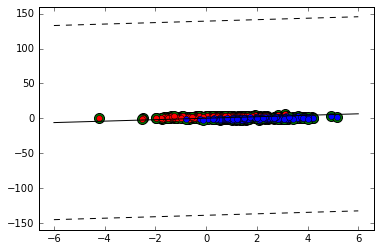

     pcost       dcost       gap    pres   dres
 0: -2.5027e+01 -4.7417e+01  9e+02  3e+01  2e+00
 1: -2.7237e+01 -2.0060e+01  3e+02  1e+01  7e-01
 2: -2.8465e+01 -1.3586e+01  2e+02  5e+00  3e-01
 3: -6.7832e+00 -3.9905e+00  7e+00  2e-01  1e-02
 4: -3.6421e+00 -3.5322e+00  9e-01  2e-02  1e-03
 5: -3.4241e+00 -3.4249e+00  4e-02  1e-03  6e-05
 6: -3.4204e+00 -3.4204e+00  4e-04  1e-05  6e-07
 7: -3.4204e+00 -3.4204e+00  4e-06  1e-07  6e-09
 8: -3.4204e+00 -3.4204e+00  4e-08  1e-09  6e-11
Optimal solution found.


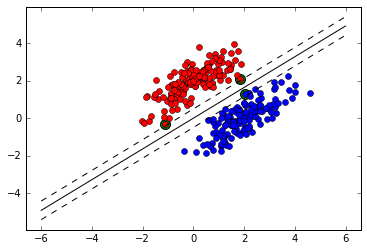

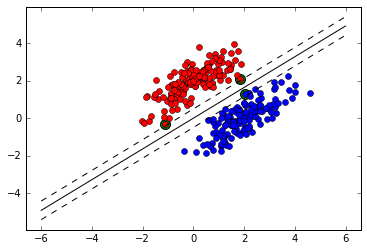

     pcost       dcost       gap    pres   dres
 0: -2.7770e+02 -6.7617e+02  4e+02  4e-14  2e+00
 1: -5.8202e+02 -5.9096e+02  9e+00  4e-14  1e+00
 2: -3.8666e+04 -3.8672e+04  6e+00  2e-12  1e+00
 3: -2.3964e+08 -2.3964e+08  4e+02  1e-08  1e+00
 4: -6.4342e+08 -6.4342e+08  1e+03  2e-07  1e+00
 5: -6.9656e+08 -6.9656e+08  1e+03  2e-07  1e+00
 6: -8.0705e+08 -8.0706e+08  1e+03  1e-07  1e+00
Terminated (singular KKT matrix).


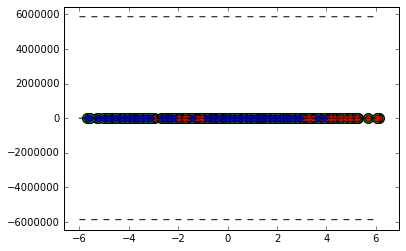

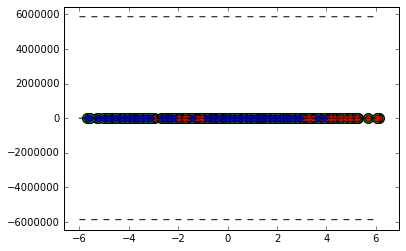

   Accuracy     Error  FN  FP  False_Positive_Rate  Precision  Sensitivity  \
0  0.963636  0.036364   3   1             0.018182   0.981132     0.945455   
1  0.963636  0.036364   2   2             0.036364   0.963636     0.963636   
2  1.000000  0.000000   0   0             0.000000   1.000000     1.000000   
3  1.000000  0.000000   0   0             0.000000   1.000000     1.000000   
4  1.000000  0.000000   0   0             0.000000   1.000000     1.000000   
5  1.000000  0.000000   0   0             0.000000   1.000000     1.000000   

   Specificity  TN  TP                      impl  
0     0.981818  54  52  self_LS Overlapping data  
1     0.963636  53  53  self_LS Overlapping data  
2     1.000000  55  55                   self_LS  
3     1.000000  55  55                 sklear_LS  
4     1.000000  55  55                  self_NLS  
5     1.000000  55  55                sklear_NLS  


In [42]:
#q2 hard margins
# intialization of the varaiable
ld_tm  = TestMetrics()
ld_matricsTotal =[]
##------------------------------------------ seperable hard margins-------------------------------
# getting the data
X1, Y1, X2, Y2 = linearSeperableOverLapData()
X_train, Y_train = trainingData(X1, Y1, X2, Y2)
X_test , Y_test = testingData(X1, Y1, X2, Y2)

clf = SVM_implementation()
clf.fit(X_train, Y_train)
Y_predict = clf.predict(X_test)

# testing the self implementation
ld_tm.setData(Y_test,Y_predict)
TP,TN,FP,FN,Classification_Accuracy,Classification_Error,Sensitivity,Specificity,False_Positive_Rate,Precision =  ld_tm.getMatrics()
ld_matricsTotal.append({"impl":"self_LS Overlapping data","TP":TP,"TN":TN,"FP":FP,"FN":FN,"Accuracy":Classification_Accuracy,"Error":Classification_Error,"Sensitivity":Sensitivity,"Specificity":Specificity,"False_Positive_Rate":False_Positive_Rate,"Precision":Precision})

plMargin(X_train[Y_train==1], X_train[Y_train==-1], clf)

### sklearn test 
ld_grad =   SVC()
ld_grad.fit(X_train,Y_train)
ld_predicted_Y_values = ld_grad.predict(X_test)

#recodring the sklearn svm 
ld_tm.setData(Y_test,ld_predicted_Y_values)
TP,TN,FP,FN,Classification_Accuracy,Classification_Error,Sensitivity,Specificity,False_Positive_Rate,Precision =  ld_tm.getMatrics()
ld_matricsTotal.append({"impl":"self_LS Overlapping data","TP":TP,"TN":TN,"FP":FP,"FN":FN,"Accuracy":Classification_Accuracy,"Error":Classification_Error,"Sensitivity":Sensitivity,"Specificity":Specificity,"False_Positive_Rate":False_Positive_Rate,"Precision":Precision})
plMargin(X_train[Y_train==1], X_train[Y_train==-1], clf)


##-----------------------------------------linear seperable linearkernal-------------------------------------
# getting the data
X1, Y1, X2, Y2 = linearSeperableData()
X_train, Y_train = trainingData(X1, Y1, X2, Y2)
X_test , Y_test = testingData(X1, Y1, X2, Y2)

# implemmeting the gaussian kernal
clf = SVM_implementation()
clf.fit(X_train, Y_train)
Y_predict = clf.predict(X_test)

# testing the self implementation
ld_tm.setData(Y_test,Y_predict)
TP,TN,FP,FN,Classification_Accuracy,Classification_Error,Sensitivity,Specificity,False_Positive_Rate,Precision =  ld_tm.getMatrics()
ld_matricsTotal.append({"impl":"self_LS","TP":TP,"TN":TN,"FP":FP,"FN":FN,"Accuracy":Classification_Accuracy,"Error":Classification_Error,"Sensitivity":Sensitivity,"Specificity":Specificity,"False_Positive_Rate":False_Positive_Rate,"Precision":Precision})
plMargin(X_train[Y_train==1], X_train[Y_train==-1], clf)
### sklearn test 
ld_grad =   SVC()
ld_grad.fit(X_train,Y_train)
ld_predicted_Y_values = ld_grad.predict(X_test)

#recodring the sklearn svm 
ld_tm.setData(Y_test,ld_predicted_Y_values)
TP,TN,FP,FN,Classification_Accuracy,Classification_Error,Sensitivity,Specificity,False_Positive_Rate,Precision =  ld_tm.getMatrics()
ld_matricsTotal.append({"impl":"sklear_LS","TP":TP,"TN":TN,"FP":FP,"FN":FN,"Accuracy":Classification_Accuracy,"Error":Classification_Error,"Sensitivity":Sensitivity,"Specificity":Specificity,"False_Positive_Rate":False_Positive_Rate,"Precision":Precision})
plMargin(X_train[Y_train==1], X_train[Y_train==-1], clf)


##-----------------------------------------non linear seperable linearkernal-------------------------------------
# getting the data
X1, Y1, X2, Y2 = nonLinearSeperableData()
X_train, Y_train = trainingData(X1, Y1, X2, Y2)
X_test , Y_test = testingData(X1, Y1, X2, Y2)

# implemmeting the gaussian kernal
clf = SVM_implementation()
clf.fit(X_train, Y_train)
Y_predict = clf.predict(X_test)

# testing the self implementation
ld_tm.setData(Y_test,Y_predict)
TP,TN,FP,FN,Classification_Accuracy,Classification_Error,Sensitivity,Specificity,False_Positive_Rate,Precision =  ld_tm.getMatrics()
ld_matricsTotal.append({"impl":"self_NLS","TP":TP,"TN":TN,"FP":FP,"FN":FN,"Accuracy":Classification_Accuracy,"Error":Classification_Error,"Sensitivity":Sensitivity,"Specificity":Specificity,"False_Positive_Rate":False_Positive_Rate,"Precision":Precision})
plMargin(X_train[Y_train==1], X_train[Y_train==-1], clf)
### sklearn test 
ld_grad =   SVC()
ld_grad.fit(X_train,Y_train)
ld_predicted_Y_values = ld_grad.predict(X_test)

#recodring the sklearn svm 
ld_tm.setData(Y_test,ld_predicted_Y_values)
TP,TN,FP,FN,Classification_Accuracy,Classification_Error,Sensitivity,Specificity,False_Positive_Rate,Precision =  ld_tm.getMatrics()
ld_matricsTotal.append({"impl":"sklear_NLS","TP":TP,"TN":TN,"FP":FP,"FN":FN,"Accuracy":Classification_Accuracy,"Error":Classification_Error,"Sensitivity":Sensitivity,"Specificity":Specificity,"False_Positive_Rate":False_Positive_Rate,"Precision":Precision})
plMargin(X_train[Y_train==1], X_train[Y_train==-1], clf)



df = pd.DataFrame(ld_matricsTotal)
print df

     pcost       dcost       gap    pres   dres
 0: -3.6582e+01 -1.1279e+02  2e+03  1e+01  1e-14
 1: -1.2579e+01 -9.2276e+01  2e+02  8e-01  1e-14
 2: -7.4643e+00 -3.3128e+01  4e+01  1e-01  5e-15
 3: -5.6121e+00 -1.1780e+01  9e+00  3e-02  4e-15
 4: -5.4410e+00 -6.9159e+00  2e+00  5e-03  4e-15
 5: -5.5625e+00 -6.1078e+00  7e-01  2e-03  4e-15
 6: -5.6218e+00 -5.8357e+00  3e-01  5e-04  4e-15
 7: -5.6617e+00 -5.7181e+00  6e-02  7e-05  3e-15
 8: -5.6822e+00 -5.6836e+00  1e-03  1e-06  4e-15
 9: -5.6828e+00 -5.6828e+00  3e-05  2e-08  5e-15
10: -5.6828e+00 -5.6828e+00  6e-07  3e-10  4e-15
Optimal solution found.


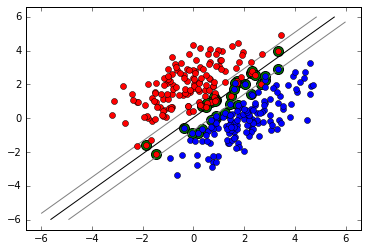

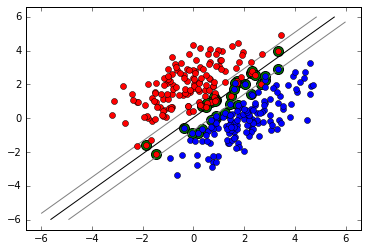

     pcost       dcost       gap    pres   dres
 0: -1.7571e+01 -1.0179e+02  1e+03  9e+00  8e-15
 1: -6.0031e+00 -8.0353e+01  2e+02  7e-01  7e-15
 2: -2.1888e+00 -1.9855e+01  2e+01  7e-02  3e-15
 3: -1.3023e+00 -4.3627e+00  4e+00  9e-03  2e-15
 4: -1.4735e+00 -2.9146e+00  2e+00  3e-03  1e-15
 5: -1.6100e+00 -2.2607e+00  7e-01  1e-03  1e-15
 6: -1.6853e+00 -2.0010e+00  3e-01  3e-04  1e-15
 7: -1.7619e+00 -1.8352e+00  7e-02  9e-07  1e-15
 8: -1.7888e+00 -1.8050e+00  2e-02  2e-07  1e-15
 9: -1.7963e+00 -1.7965e+00  2e-04  2e-09  1e-15
10: -1.7964e+00 -1.7964e+00  2e-06  2e-11  1e-15
11: -1.7964e+00 -1.7964e+00  2e-08  2e-13  1e-15
Optimal solution found.


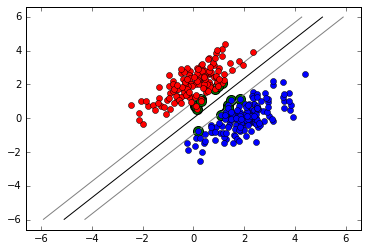

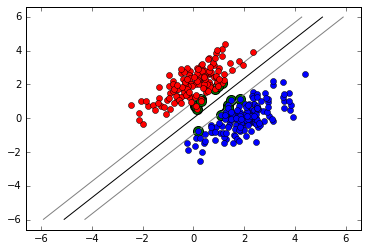

   Accuracy     Error  FN  FP  False_Positive_Rate  Precision  Sensitivity  \
0  1.000000  0.000000   0   0             0.000000   1.000000          1.0   
1  0.990909  0.009091   0   1             0.018182   0.982143          1.0   
2  1.000000  0.000000   0   0             0.000000   1.000000          1.0   
3  1.000000  0.000000   0   0             0.000000   1.000000          1.0   

   Specificity  TN  TP          impl  
0     1.000000  55  55    self_nonLS  
1     0.981818  54  55  sklear_nonLS  
2     1.000000  55  55       self_LS  
3     1.000000  55  55     sklear_LS  


In [43]:
#q4 this is for the soft margin giving c values
ld_tm  = TestMetrics()
ld_matricsTotal =[]
##-----------------------------------non linear seperable------------------
X1, Y1, X2, Y2 = linearSeperableOverLapData()
X_train, Y_train = trainingData(X1, Y1, X2, Y2)
X_test , Y_test  = testingData(X1, Y1, X2, Y2)

# self implementation
clf = SVM_implementation(C=0.23)
clf.fit(X_train, Y_train)
Y_predict = clf.predict(X_test)

ld_tm.setData(Y_test,Y_predict)
TP,TN,FP,FN,Classification_Accuracy,Classification_Error,Sensitivity,Specificity,False_Positive_Rate,Precision =  ld_tm.getMatrics()
ld_matricsTotal.append({"impl":"self_nonLS","TP":TP,"TN":TN,"FP":FP,"FN":FN,"Accuracy":Classification_Accuracy,"Error":Classification_Error,"Sensitivity":Sensitivity,"Specificity":Specificity,"False_Positive_Rate":False_Positive_Rate,"Precision":Precision})
plContour(X_train[Y_train==1], X_train[Y_train==-1], clf)

### sklearn test 
ld_grad =   SVC(C=0.23)
ld_grad.fit(X_train,Y_train)
ld_predicted_Y_values = ld_grad.predict(X_test)

ld_tm.setData(Y_test,ld_predicted_Y_values)
TP,TN,FP,FN,Classification_Accuracy,Classification_Error,Sensitivity,Specificity,False_Positive_Rate,Precision =  ld_tm.getMatrics()
ld_matricsTotal.append({"impl":"sklear_nonLS","TP":TP,"TN":TN,"FP":FP,"FN":FN,"Accuracy":Classification_Accuracy,"Error":Classification_Error,"Sensitivity":Sensitivity,"Specificity":Specificity,"False_Positive_Rate":False_Positive_Rate,"Precision":Precision})

plContour(X_train[Y_train==1], X_train[Y_train==-1], clf)

##-----------------------------------linear seperable--------------------------------
X1, Y1, X2, Y2 = linearSeperableData()
X_train, Y_train = trainingData(X1, Y1, X2, Y2)
X_test , Y_test  = testingData(X1, Y1, X2, Y2)

# self implementation
clf = SVM_implementation(C=0.23)
clf.fit(X_train, Y_train)
Y_predict = clf.predict(X_test)

ld_tm.setData(Y_test,Y_predict)
TP,TN,FP,FN,Classification_Accuracy,Classification_Error,Sensitivity,Specificity,False_Positive_Rate,Precision =  ld_tm.getMatrics()
ld_matricsTotal.append({"impl":"self_LS","TP":TP,"TN":TN,"FP":FP,"FN":FN,"Accuracy":Classification_Accuracy,"Error":Classification_Error,"Sensitivity":Sensitivity,"Specificity":Specificity,"False_Positive_Rate":False_Positive_Rate,"Precision":Precision})
plContour(X_train[Y_train==1], X_train[Y_train==-1], clf)

### sklearn test 
ld_grad =   SVC(C=0.23)
ld_grad.fit(X_train,Y_train)
ld_predicted_Y_values = ld_grad.predict(X_test)

ld_tm.setData(Y_test,ld_predicted_Y_values)
TP,TN,FP,FN,Classification_Accuracy,Classification_Error,Sensitivity,Specificity,False_Positive_Rate,Precision =  ld_tm.getMatrics()
ld_matricsTotal.append({"impl":"sklear_LS","TP":TP,"TN":TN,"FP":FP,"FN":FN,"Accuracy":Classification_Accuracy,"Error":Classification_Error,"Sensitivity":Sensitivity,"Specificity":Specificity,"False_Positive_Rate":False_Positive_Rate,"Precision":Precision})

plContour(X_train[Y_train==1], X_train[Y_train==-1], clf)

df = pd.DataFrame(ld_matricsTotal)
print df

     pcost       dcost       gap    pres   dres
 0: -6.7701e+01 -2.0244e+02  8e+02  2e+01  2e+00
 1: -9.5888e+01 -2.4208e+02  3e+02  7e+00  6e-01
 2: -1.5405e+02 -2.9758e+02  2e+02  5e+00  4e-01
 3: -2.0119e+02 -3.0968e+02  2e+02  3e+00  2e-01
 4: -2.4369e+02 -3.5322e+02  1e+02  1e+00  1e-01
 5: -2.9698e+02 -3.1950e+02  3e+01  2e-01  2e-02
 6: -3.0985e+02 -3.1105e+02  1e+00  7e-03  6e-04
 7: -3.1074e+02 -3.1075e+02  1e-02  7e-05  6e-06
 8: -3.1075e+02 -3.1075e+02  1e-04  7e-07  6e-08
 9: -3.1075e+02 -3.1075e+02  1e-06  7e-09  6e-10
Optimal solution found.


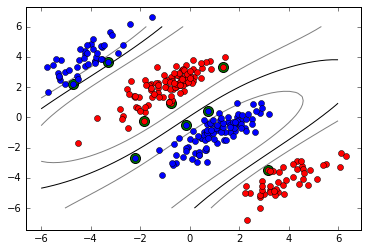

     pcost       dcost       gap    pres   dres
 0: -5.7602e+01 -1.7102e+02  1e+03  3e+01  3e+00
 1: -1.1934e+02 -2.9217e+02  1e+03  2e+01  2e+00
 2: -4.7774e+02 -8.8111e+02  1e+03  2e+01  2e+00
 3: -7.2921e+02 -1.2577e+03  1e+03  2e+01  2e+00
 4: -2.2021e+03 -3.0232e+03  1e+03  1e+01  1e+00
 5: -2.8672e+03 -3.8415e+03  1e+03  1e+01  1e+00
 6: -7.4528e+03 -9.0838e+03  2e+03  1e+01  1e+00
 7: -1.3950e+04 -1.6460e+04  3e+03  1e+01  1e+00
 8: -5.6483e+04 -6.2069e+04  6e+03  1e+01  1e+00
 9: -7.3715e+04 -8.0541e+04  7e+03  1e+01  1e+00
10: -2.0457e+05 -2.1962e+05  2e+04  1e+01  1e+00
11: -6.3766e+05 -6.7638e+05  4e+04  1e+01  1e+00
12: -1.9525e+06 -2.0547e+06  1e+05  1e+01  1e+00
13: -3.6865e+06 -3.8671e+06  2e+05  1e+01  1e+00
14: -6.9559e+06 -7.2758e+06  3e+05  1e+01  1e+00
15: -7.1628e+06 -7.4913e+06  3e+05  1e+01  1e+00
16: -1.4667e+07 -1.5299e+07  6e+05  1e+01  1e+00
17: -1.4713e+07 -1.5346e+07  6e+05  1e+01  1e+00
18: -1.8624e+07 -1.9412e+07  8e+05  1e+01  1e+00
19: -2.2801e+07 -2.37

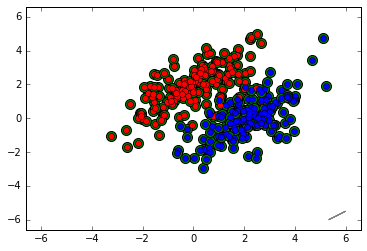

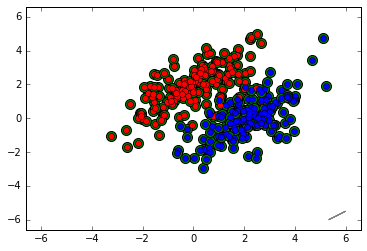

     pcost       dcost       gap    pres   dres
 0: -2.6332e+01 -6.4066e+01  8e+02  3e+01  2e+00
 1: -2.2359e+01 -6.1384e+01  3e+02  8e+00  6e-01
 2: -3.6859e+01 -7.9633e+01  2e+02  6e+00  4e-01
 3: -5.7848e+01 -1.1625e+02  2e+02  2e+00  1e-01
 4: -6.5800e+01 -9.3968e+01  6e+01  7e-01  5e-02
 5: -7.4917e+01 -8.4943e+01  1e+01  2e-14  2e-14
 6: -8.3812e+01 -8.4002e+01  2e-01  2e-14  2e-14
 7: -8.3981e+01 -8.3983e+01  3e-03  3e-14  3e-14
 8: -8.3983e+01 -8.3983e+01  5e-05  2e-14  3e-14
Optimal solution found.


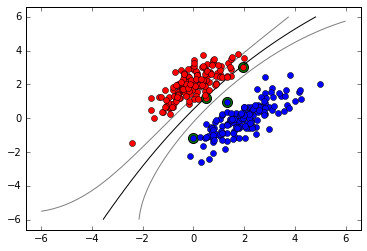

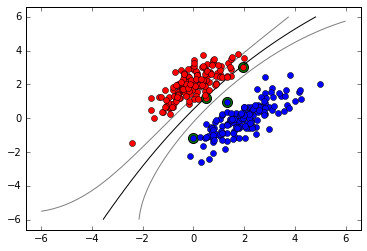

     pcost       dcost       gap    pres   dres
 0: -7.4559e+00 -1.3197e+01  6e+02  2e+01  2e+00
 1: -4.9704e+00 -1.7152e+00  9e+01  3e+00  2e-01
 2: -1.0031e-01 -4.6551e-01  3e+00  9e-02  7e-03
 3: -4.7479e-02 -2.9383e-01  8e-01  2e-02  2e-03
 4: -6.4950e-02 -1.5350e-01  3e-01  6e-03  5e-04
 5: -7.2917e-02 -1.1251e-01  2e-01  4e-03  3e-04
 6: -7.3184e-02 -7.6427e-02  1e-01  2e-03  2e-04
 7: -6.7918e-02 -4.9950e-02  7e-02  1e-03  8e-05
 8: -5.3187e-02 -3.0677e-02  4e-02  5e-04  4e-05
 9: -3.5139e-02 -2.1702e-02  2e-02  2e-04  2e-05
10: -2.2525e-02 -1.8677e-02  7e-03  5e-05  4e-06
11: -2.1270e-02 -1.8406e-02  7e-03  4e-05  3e-06
12: -1.8280e-02 -1.7828e-02  4e-03  2e-05  1e-06
13: -1.7974e-02 -1.7695e-02  4e-03  1e-05  1e-06
14: -1.7367e-02 -1.7300e-02  3e-03  1e-05  8e-07
15: -1.7028e-02 -1.6550e-02  3e-03  7e-06  5e-07
16: -1.6138e-02 -1.5270e-02  2e-03  4e-06  3e-07
17: -1.5871e-02 -1.5385e-02  2e-03  4e-06  3e-07
18: -1.5215e-02 -1.5195e-02  2e-03  2e-06  2e-07
19: -1.4457e-02 -1.51

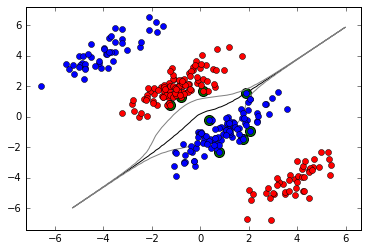

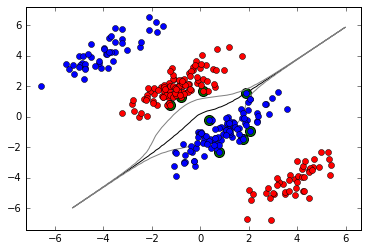

     pcost       dcost       gap    pres   dres
 0: -2.5797e+01 -6.1319e+01  9e+02  2e+01  2e+00
 1: -7.7242e+01 -1.1989e+02  7e+02  1e+01  2e+00
 2: -2.5827e+02 -3.7757e+02  7e+02  1e+01  1e+00
 3: -8.0108e+02 -9.8493e+02  7e+02  1e+01  1e+00
 4: -9.7880e+02 -1.1925e+03  7e+02  1e+01  1e+00
 5: -2.5522e+03 -2.8993e+03  9e+02  1e+01  1e+00
 6: -3.0949e+03 -3.5055e+03  9e+02  1e+01  1e+00
 7: -6.0218e+03 -6.7131e+03  1e+03  1e+01  1e+00
 8: -1.6970e+04 -1.8424e+04  2e+03  1e+01  1e+00
 9: -3.4396e+04 -3.7043e+04  4e+03  1e+01  1e+00
10: -6.3938e+04 -6.8489e+04  6e+03  1e+01  1e+00
11: -9.3536e+04 -9.9934e+04  8e+03  1e+01  1e+00
12: -1.0981e+05 -1.1718e+05  9e+03  1e+01  1e+00
13: -1.6371e+05 -1.7408e+05  1e+04  1e+01  1e+00
14: -1.9571e+05 -2.0780e+05  2e+04  1e+01  1e+00
15: -2.3872e+05 -2.5308e+05  2e+04  1e+01  1e+00
16: -2.6970e+05 -2.8563e+05  2e+04  1e+01  1e+00
17: -2.7956e+05 -2.9592e+05  3e+04  1e+01  1e+00
18: -2.9718e+05 -3.1429e+05  3e+04  1e+01  1e+00
19: -3.0670e+05 -3.24

     pcost       dcost       gap    pres   dres
 0: -2.6427e+00 -4.9888e+00  7e+02  2e+01  2e+00
 1: -2.0093e+00 -1.7841e+00  5e+01  2e+00  1e-01
 2: -5.4084e-01 -9.3718e-01  7e+00  2e-01  2e-02
 3: -4.8263e-01 -4.7210e-01  2e+00  5e-02  4e-03
 4: -4.0363e-01 -3.3032e-01  1e+00  3e-02  2e-03
 5: -2.7322e-01 -2.4137e-01  2e-01  5e-03  4e-04
 6: -2.3339e-01 -2.1887e-01  1e-01  2e-03  1e-04
 7: -2.1829e-01 -2.1012e-01  6e-02  9e-04  7e-05
 8: -2.0979e-01 -2.0410e-01  4e-02  5e-04  4e-05
 9: -2.0599e-01 -2.0196e-01  3e-02  3e-04  2e-05
10: -2.0202e-01 -1.9856e-01  3e-02  3e-04  2e-05
11: -1.9937e-01 -1.9556e-01  2e-02  2e-04  1e-05
12: -1.9441e-01 -1.8960e-01  2e-02  1e-04  7e-06
13: -1.8827e-01 -1.8694e-01  4e-03  2e-05  2e-06
14: -1.8476e-01 -1.8702e-01  4e-03  7e-06  5e-07
15: -1.8652e-01 -1.8671e-01  2e-04  2e-07  1e-08
16: -1.8668e-01 -1.8669e-01  1e-05  2e-09  2e-10
17: -1.8669e-01 -1.8669e-01  2e-07  2e-11  2e-12
Optimal solution found.


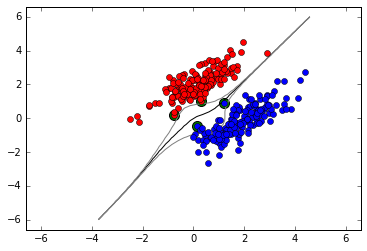

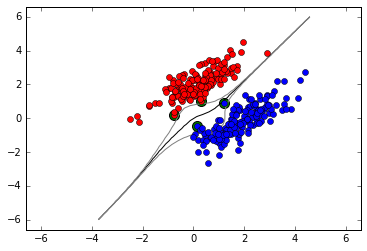

    Accuracy     Error  FN  FP  False_Positive_Rate  Precision  Sensitivity  \
0   0.972727  0.027273   0   3             0.054545   0.948276     1.000000   
1   1.000000  0.000000   0   0             0.000000   1.000000     1.000000   
2   0.500000  0.500000   0  55             1.000000   0.500000     1.000000   
3   0.981818  0.018182   1   1             0.018182   0.981818     0.981818   
4   0.990909  0.009091   1   0             0.000000   1.000000     0.981818   
5   1.000000  0.000000   0   0             0.000000   1.000000     1.000000   
6   0.000000  1.000000  55  55             1.000000   0.000000     0.000000   
7   0.909091  0.090909   6   4             0.072727   0.924528     0.890909   
8   0.954545  0.045455   4   1             0.018182   0.980769     0.927273   
9   0.963636  0.036364   4   0             0.000000   1.000000     0.927273   
10  1.000000  0.000000   0   0             0.000000   1.000000     1.000000   
11  1.000000  0.000000   0   0             0.000000 

In [57]:
## Q5 checking gaussian kernal

# intialization of the varaiable
ld_tm  = TestMetrics()
ld_matricsTotal =[]
##------------------------------------------non linear seperable gaussian kernal-------------------------------
# getting the data
X1, Y1, X2, Y2 = nonLinearSeperableData()
X_train, Y_train = trainingData(X1, Y1, X2, Y2)
X_test , Y_test = testingData(X1, Y1, X2, Y2)

# implemmeting the gaussian kernal
clf = SVM_implementation(gaussian_kernel)
clf.fit(X_train, Y_train)
Y_predict = clf.predict(X_test)

# testing the self implementation
ld_tm.setData(Y_test,Y_predict)
TP,TN,FP,FN,Classification_Accuracy,Classification_Error,Sensitivity,Specificity,False_Positive_Rate,Precision =  ld_tm.getMatrics()
ld_matricsTotal.append({"impl":"gaussian_self_NLS","TP":TP,"TN":TN,"FP":FP,"FN":FN,"Accuracy":Classification_Accuracy,"Error":Classification_Error,"Sensitivity":Sensitivity,"Specificity":Specificity,"False_Positive_Rate":False_Positive_Rate,"Precision":Precision})
plContour(X_train[Y_train==1], X_train[Y_train==-1], clf)

### sklearn test 
ld_grad =   SVC()
ld_grad.fit(X_train,Y_train)
ld_predicted_Y_values = ld_grad.predict(X_test)

#recodring the sklearn svm 
ld_tm.setData(Y_test,ld_predicted_Y_values)
TP,TN,FP,FN,Classification_Accuracy,Classification_Error,Sensitivity,Specificity,False_Positive_Rate,Precision =  ld_tm.getMatrics()
ld_matricsTotal.append({"impl":"gauss_sklear_NLS","TP":TP,"TN":TN,"FP":FP,"FN":FN,"Accuracy":Classification_Accuracy,"Error":Classification_Error,"Sensitivity":Sensitivity,"Specificity":Specificity,"False_Positive_Rate":False_Positive_Rate,"Precision":Precision})
plContour(X_train[Y_train==1], X_train[Y_train==-1], clf)


##-----------------------------------------linear seperable gaussian kernal--------------------------------------
# getting the data
X1, Y1, X2, Y2 = linearSeperableOverLapData()
X_train, Y_train = trainingData(X1, Y1, X2, Y2)
X_test , Y_test = testingData(X1, Y1, X2, Y2)

# implemmeting the gaussian kernal
clf = SVM_implementation(gaussian_kernel)
clf.fit(X_train, Y_train)
Y_predict = clf.predict(X_test)

# testing the self implementation
ld_tm.setData(Y_test,Y_predict)
TP,TN,FP,FN,Classification_Accuracy,Classification_Error,Sensitivity,Specificity,False_Positive_Rate,Precision =  ld_tm.getMatrics()
ld_matricsTotal.append({"impl":"gauss_self_LSO","TP":TP,"TN":TN,"FP":FP,"FN":FN,"Accuracy":Classification_Accuracy,"Error":Classification_Error,"Sensitivity":Sensitivity,"Specificity":Specificity,"False_Positive_Rate":False_Positive_Rate,"Precision":Precision})
plContour(X_train[Y_train==1], X_train[Y_train==-1], clf)
### sklearn test 
ld_grad =   SVC()
ld_grad.fit(X_train,Y_train)
ld_predicted_Y_values = ld_grad.predict(X_test)

#recodring the sklearn svm 
ld_tm.setData(Y_test,ld_predicted_Y_values)
TP,TN,FP,FN,Classification_Accuracy,Classification_Error,Sensitivity,Specificity,False_Positive_Rate,Precision =  ld_tm.getMatrics()
ld_matricsTotal.append({"impl":"gauss_sklear_LSO","TP":TP,"TN":TN,"FP":FP,"FN":FN,"Accuracy":Classification_Accuracy,"Error":Classification_Error,"Sensitivity":Sensitivity,"Specificity":Specificity,"False_Positive_Rate":False_Positive_Rate,"Precision":Precision})
plContour(X_train[Y_train==1], X_train[Y_train==-1], clf)


##-----------------------------------------linear seperable overlaping gaussian kernal--------------------------------------
# getting the data
X1, Y1, X2, Y2 = linearSeperableData()
X_train, Y_train = trainingData(X1, Y1, X2, Y2)
X_test , Y_test = testingData(X1, Y1, X2, Y2)

# implemmeting the gaussian kernal
clf = SVM_implementation(gaussian_kernel)
clf.fit(X_train, Y_train)
Y_predict = clf.predict(X_test)

# testing the self implementation
ld_tm.setData(Y_test,Y_predict)
TP,TN,FP,FN,Classification_Accuracy,Classification_Error,Sensitivity,Specificity,False_Positive_Rate,Precision =  ld_tm.getMatrics()
ld_matricsTotal.append({"impl":"gauss_self_LS","TP":TP,"TN":TN,"FP":FP,"FN":FN,"Accuracy":Classification_Accuracy,"Error":Classification_Error,"Sensitivity":Sensitivity,"Specificity":Specificity,"False_Positive_Rate":False_Positive_Rate,"Precision":Precision})
plContour(X_train[Y_train==1], X_train[Y_train==-1], clf)
### sklearn test 
ld_grad =   SVC()
ld_grad.fit(X_train,Y_train)
ld_predicted_Y_values = ld_grad.predict(X_test)

#recodring the sklearn svm 
ld_tm.setData(Y_test,ld_predicted_Y_values)
TP,TN,FP,FN,Classification_Accuracy,Classification_Error,Sensitivity,Specificity,False_Positive_Rate,Precision =  ld_tm.getMatrics()
ld_matricsTotal.append({"impl":"gauss_sklear_LS","TP":TP,"TN":TN,"FP":FP,"FN":FN,"Accuracy":Classification_Accuracy,"Error":Classification_Error,"Sensitivity":Sensitivity,"Specificity":Specificity,"False_Positive_Rate":False_Positive_Rate,"Precision":Precision})
plContour(X_train[Y_train==1], X_train[Y_train==-1], clf)

##-0---------------------------------------------------------------------------------------------------------
##--------------------------------------------------------------------------------------------------------------
##------------------------------------------non linear seperable polynomia kernal-------------------------------
# getting the data
X1, Y1, X2, Y2 = nonLinearSeperableData()
X_train, Y_train = trainingData(X1, Y1, X2, Y2)
X_test , Y_test = testingData(X1, Y1, X2, Y2)

# implemmeting the gaussian kernal
clf = SVM_implementation(polynomialKernel)
clf.fit(X_train, Y_train)
Y_predict = clf.predict(X_test)

# testing the self implementation
ld_tm.setData(Y_test,Y_predict)
TP,TN,FP,FN,Classification_Accuracy,Classification_Error,Sensitivity,Specificity,False_Positive_Rate,Precision =  ld_tm.getMatrics()
ld_matricsTotal.append({"impl":"poly_self_NLS","TP":TP,"TN":TN,"FP":FP,"FN":FN,"Accuracy":Classification_Accuracy,"Error":Classification_Error,"Sensitivity":Sensitivity,"Specificity":Specificity,"False_Positive_Rate":False_Positive_Rate,"Precision":Precision})
plContour(X_train[Y_train==1], X_train[Y_train==-1], clf)

### sklearn test 
ld_grad =   SVC(kernel = 'poly')
ld_grad.fit(X_train,Y_train)
ld_predicted_Y_values = ld_grad.predict(X_test)

#recodring the sklearn svm 
ld_tm.setData(Y_test,ld_predicted_Y_values)
TP,TN,FP,FN,Classification_Accuracy,Classification_Error,Sensitivity,Specificity,False_Positive_Rate,Precision =  ld_tm.getMatrics()
ld_matricsTotal.append({"impl":"poly_sklear_NLS","TP":TP,"TN":TN,"FP":FP,"FN":FN,"Accuracy":Classification_Accuracy,"Error":Classification_Error,"Sensitivity":Sensitivity,"Specificity":Specificity,"False_Positive_Rate":False_Positive_Rate,"Precision":Precision})
plContour(X_train[Y_train==1], X_train[Y_train==-1], clf)


##-----------------------------------------linear seperable polynomia kernal--------------------------------------
# getting the data
X1, Y1, X2, Y2 = linearSeperableOverLapData()
X_train, Y_train = trainingData(X1, Y1, X2, Y2)
X_test , Y_test = testingData(X1, Y1, X2, Y2)

# implemmeting the gaussian kernal
clf = SVM_implementation(polynomialKernel)
clf.fit(X_train, Y_train)
Y_predict = clf.predict(X_test)

# testing the self implementation
ld_tm.setData(Y_test,Y_predict)
TP,TN,FP,FN,Classification_Accuracy,Classification_Error,Sensitivity,Specificity,False_Positive_Rate,Precision =  ld_tm.getMatrics()
ld_matricsTotal.append({"impl":"poly_self_LSO","TP":TP,"TN":TN,"FP":FP,"FN":FN,"Accuracy":Classification_Accuracy,"Error":Classification_Error,"Sensitivity":Sensitivity,"Specificity":Specificity,"False_Positive_Rate":False_Positive_Rate,"Precision":Precision})
plContour(X_train[Y_train==1], X_train[Y_train==-1], clf)
### sklearn test 
ld_grad =   SVC(kernel ='poly')
ld_grad.fit(X_train,Y_train)
ld_predicted_Y_values = ld_grad.predict(X_test)

#recodring the sklearn svm 
ld_tm.setData(Y_test,ld_predicted_Y_values)
TP,TN,FP,FN,Classification_Accuracy,Classification_Error,Sensitivity,Specificity,False_Positive_Rate,Precision =  ld_tm.getMatrics()
ld_matricsTotal.append({"impl":"poly_sklear__LSO","TP":TP,"TN":TN,"FP":FP,"FN":FN,"Accuracy":Classification_Accuracy,"Error":Classification_Error,"Sensitivity":Sensitivity,"Specificity":Specificity,"False_Positive_Rate":False_Positive_Rate,"Precision":Precision})
plContour(X_train[Y_train==1], X_train[Y_train==-1], clf)


##-----------------------------------------linear seperable overlaping polynomia kernal--------------------------------------
# getting the data
X1, Y1, X2, Y2 = linearSeperableData()
X_train, Y_train = trainingData(X1, Y1, X2, Y2)
X_test , Y_test = testingData(X1, Y1, X2, Y2)

# implemmeting the gaussian kernal
clf = SVM_implementation(polynomialKernel)
clf.fit(X_train, Y_train)
Y_predict = clf.predict(X_test)

# testing the self implementation
ld_tm.setData(Y_test,Y_predict)
TP,TN,FP,FN,Classification_Accuracy,Classification_Error,Sensitivity,Specificity,False_Positive_Rate,Precision =  ld_tm.getMatrics()
ld_matricsTotal.append({"impl":"poly_self_LS","TP":TP,"TN":TN,"FP":FP,"FN":FN,"Accuracy":Classification_Accuracy,"Error":Classification_Error,"Sensitivity":Sensitivity,"Specificity":Specificity,"False_Positive_Rate":False_Positive_Rate,"Precision":Precision})
plContour(X_train[Y_train==1], X_train[Y_train==-1], clf)
### sklearn test 
ld_grad =   SVC(kernel = 'poly')
ld_grad.fit(X_train,Y_train)
ld_predicted_Y_values = ld_grad.predict(X_test)

#recodring the sklearn svm 
ld_tm.setData(Y_test,ld_predicted_Y_values)
TP,TN,FP,FN,Classification_Accuracy,Classification_Error,Sensitivity,Specificity,False_Positive_Rate,Precision =  ld_tm.getMatrics()
ld_matricsTotal.append({"impl":"poly_sklearn_LS","TP":TP,"TN":TN,"FP":FP,"FN":FN,"Accuracy":Classification_Accuracy,"Error":Classification_Error,"Sensitivity":Sensitivity,"Specificity":Specificity,"False_Positive_Rate":False_Positive_Rate,"Precision":Precision})
plContour(X_train[Y_train==1], X_train[Y_train==-1], clf)

df = pd.DataFrame(ld_matricsTotal)
print df

X1_train (500L, 2L)
     pcost       dcost       gap    pres   dres
 0: -6.9486e+01 -1.9795e+02  3e+03  5e+01  2e+00
 1: -1.6064e+02 -3.4440e+02  2e+03  4e+01  2e+00
 2: -5.1093e+02 -8.9113e+02  2e+03  3e+01  2e+00
 3: -1.4995e+03 -2.3295e+03  2e+03  3e+01  1e+00
 4: -2.4439e+03 -3.6196e+03  3e+03  3e+01  1e+00
 5: -6.8513e+03 -8.7994e+03  3e+03  2e+01  1e+00
 6: -7.6846e+03 -9.7313e+03  3e+03  2e+01  1e+00
 7: -1.3221e+04 -1.5849e+04  4e+03  2e+01  1e+00
 8: -5.2269e+04 -5.7436e+04  6e+03  2e+01  1e+00
 9: -1.5212e+05 -1.6307e+05  1e+04  2e+01  1e+00
10: -6.2405e+05 -6.5710e+05  3e+04  2e+01  1e+00
11: -6.8244e+05 -7.1827e+05  4e+04  2e+01  1e+00
12: -2.1053e+06 -2.2048e+06  1e+05  2e+01  1e+00
13: -2.4591e+06 -2.5746e+06  1e+05  2e+01  1e+00
14: -4.3292e+06 -4.5282e+06  2e+05  2e+01  1e+00
15: -1.2056e+07 -1.2609e+07  6e+05  2e+01  1e+00
16: -2.4243e+07 -2.5463e+07  1e+06  2e+01  1e+00
17: -5.1918e+07 -5.5239e+07  3e+06  2e+01  1e+00
18: -1.2680e+08 -1.3976e+08  1e+07  2e+01  1e+00
1

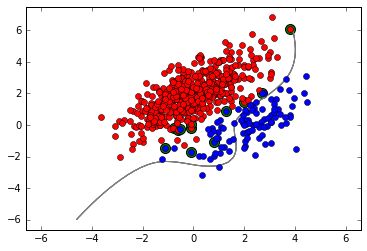

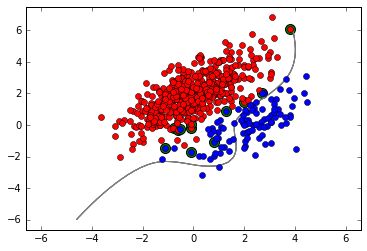

     pcost       dcost       gap    pres   dres
 0: -9.5472e+01 -2.2269e+02  2e+03  4e+01  2e+00
 1: -1.7217e+02 -2.7604e+02  2e+03  3e+01  2e+00
 2: -3.7797e+02 -5.9541e+02  2e+03  3e+01  2e+00
 3: -3.1158e+03 -4.4429e+03  2e+03  3e+01  1e+00
 4: -3.9963e+03 -5.5929e+03  2e+03  3e+01  1e+00
 5: -1.2928e+04 -1.5424e+04  3e+03  2e+01  1e+00
 6: -6.8980e+04 -7.3251e+04  4e+03  2e+01  1e+00
 7: -4.0825e+05 -4.2629e+05  2e+04  2e+01  1e+00
 8: -1.2420e+06 -1.2921e+06  5e+04  2e+01  1e+00
 9: -3.0632e+07 -3.0732e+07  1e+05  2e+01  1e+00
10: -6.9547e+09 -6.9607e+09  6e+06  2e+01  1e+00
11: -4.4766e+10 -4.4804e+10  4e+07  2e+01  1e+00
12: -6.7441e+10 -6.7499e+10  6e+07  2e+01  1e+00
13: -8.9034e+10 -8.9110e+10  8e+07  2e+01  1e+00
14: -1.2993e+11 -1.3004e+11  1e+08  2e+01  1e+00
15: -2.0206e+11 -2.0223e+11  2e+08  2e+01  1e+00
16: -2.7068e+11 -2.7090e+11  2e+08  2e+01  1e+00
Terminated (singular KKT matrix).


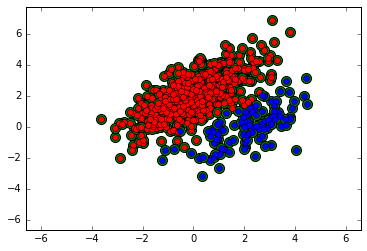

     pcost       dcost       gap    pres   dres
 0: -5.8755e+01 -2.3276e+02  3e+03  1e+01  2e-14
 1: -1.9770e+01 -1.8859e+02  4e+02  8e-01  2e-14
 2: -1.1237e+01 -6.2416e+01  8e+01  1e-01  7e-15
 3: -7.9527e+00 -2.0198e+01  2e+01  3e-02  5e-15
 4: -7.0440e+00 -1.0683e+01  5e+00  8e-03  3e-15
 5: -7.0535e+00 -7.8005e+00  1e+00  1e-03  4e-15
 6: -7.0950e+00 -7.2581e+00  2e-01  3e-04  3e-15
 7: -7.1098e+00 -7.1397e+00  4e-02  4e-05  3e-15
 8: -7.1156e+00 -7.1177e+00  2e-03  1e-06  4e-15
 9: -7.1163e+00 -7.1163e+00  4e-05  2e-08  3e-15
10: -7.1163e+00 -7.1163e+00  4e-07  2e-10  4e-15
Optimal solution found.


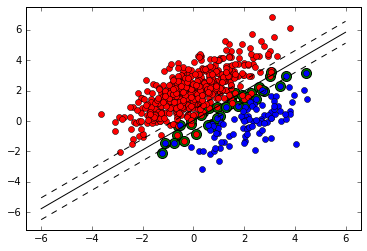

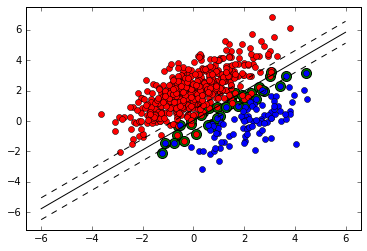

   Accuracy     Error  FN   FP  False_Positive_Rate  Precision  Sensitivity  \
0  0.921667  0.078333   1   46                 0.46   0.915596        0.998   
1  0.975000  0.025000   5   10                 0.10   0.980198        0.990   
2  0.833333  0.166667   0  100                 1.00   0.833333        1.000   
3  0.980000  0.020000   6    6                 0.06   0.988000        0.988   
4  0.980000  0.020000   9    3                 0.03   0.993927        0.982   
5  0.975000  0.025000   5   10                 0.10   0.980198        0.990   

   Specificity  TN   TP         impl  
0         0.54  54  499         self  
1         0.90  90  495       sklear  
2         0.00   0  500    self_hard  
3         0.94  94  494  sklearnHard  
4         0.97  97  491    self_hard  
5         0.90  90  495  sklearnHard  


In [47]:
#q6

# generate training data in the 2-d case
mean_1,mean_2 = np.array([0, 2]),np.array([2, 0])
cov = np.array([[1.5, 1.0], [1.0, 1.5]])

X_1 = np.random.multivariate_normal(mean_1, cov, 1000)
Y_1 = np.ones(len(X_1))

X_2 = np.random.multivariate_normal(mean_2, cov, 200)
Y_2 = np.ones(len(X_2)) * -1

X1_train,Y1_train = X_1[:int(round(len(X_1)/2))],Y_1[:int(round(len(X_1)/2))]
X2_train,Y2_train = X_2[:int(round(len(X_2)/2))],Y_2[:int(round(len(X_2)/2))]
X_train = np.vstack((X1_train, X2_train))
Y_train = np.hstack((Y1_train, Y2_train))

X1_test,Y1_test = X_1[int(round(len(X_1)/2)):],Y_1[int(round(len(X_1)/2)):]
X2_test,Y2_test = X_2[int(round(len(X_2)/2)):],Y_2[int(round(len(X_2)/2)):]
X_test = np.vstack((X1_test, X2_test))
Y_test = np.hstack((Y1_test, Y2_test))

ld_tm  = TestMetrics()
ld_matricsTotal =[]

print "X1_train",X1_train.shape
##------------------------------------------non linear seperable gaussian kernal-------------------------------
# getting the data
# X1, Y1, X2, Y2 = nonLinearSeperableData()
# X_train, Y_train = trainingData(X1, Y1, X2, Y2)
# X_test , Y_test = testingData(X1, Y1, X2, Y2)

# implemmeting the gaussian kernal
clf = SVM_implementation(gaussian_kernel)
clf.fit(X_train, Y_train)
Y_predict = clf.predict(X_test)

# testing the self implementation
ld_tm.setData(Y_test,Y_predict)
TP,TN,FP,FN,Classification_Accuracy,Classification_Error,Sensitivity,Specificity,False_Positive_Rate,Precision =  ld_tm.getMatrics()
ld_matricsTotal.append({"impl":"self","TP":TP,"TN":TN,"FP":FP,"FN":FN,"Accuracy":Classification_Accuracy,"Error":Classification_Error,"Sensitivity":Sensitivity,"Specificity":Specificity,"False_Positive_Rate":False_Positive_Rate,"Precision":Precision})
plContour(X_train[Y_train==1], X_train[Y_train==-1], clf)

### sklearn test 
ld_grad =   SVC(C=0.23)
ld_grad.fit(X_train,Y_train)
ld_predicted_Y_values = ld_grad.predict(X_test)

#recodring the sklearn svm 
ld_tm.setData(Y_test,ld_predicted_Y_values)
TP,TN,FP,FN,Classification_Accuracy,Classification_Error,Sensitivity,Specificity,False_Positive_Rate,Precision =  ld_tm.getMatrics()
ld_matricsTotal.append({"impl":"sklear","TP":TP,"TN":TN,"FP":FP,"FN":FN,"Accuracy":Classification_Accuracy,"Error":Classification_Error,"Sensitivity":Sensitivity,"Specificity":Specificity,"False_Positive_Rate":False_Positive_Rate,"Precision":Precision})
plContour(X_train[Y_train==1], X_train[Y_train==-1], clf)

##------------------------------------------  hard margins-------------------------------
# getting the data

clf = SVM_implementation()
clf.fit(X_train, Y_train)
Y_predict = clf.predict(X_test)

# testing the self implementation
ld_tm.setData(Y_test,Y_predict)
TP,TN,FP,FN,Classification_Accuracy,Classification_Error,Sensitivity,Specificity,False_Positive_Rate,Precision =  ld_tm.getMatrics()
ld_matricsTotal.append({"impl":"self_hard","TP":TP,"TN":TN,"FP":FP,"FN":FN,"Accuracy":Classification_Accuracy,"Error":Classification_Error,"Sensitivity":Sensitivity,"Specificity":Specificity,"False_Positive_Rate":False_Positive_Rate,"Precision":Precision})

plContour(X_train[Y_train==1], X_train[Y_train==-1], clf)

### sklearn test 
ld_grad =   SVC()
ld_grad.fit(X_train,Y_train)
ld_predicted_Y_values = ld_grad.predict(X_test)

#recodring the sklearn svm 
ld_tm.setData(Y_test,ld_predicted_Y_values)
TP,TN,FP,FN,Classification_Accuracy,Classification_Error,Sensitivity,Specificity,False_Positive_Rate,Precision =  ld_tm.getMatrics()
ld_matricsTotal.append({"impl":"sklearnHard","TP":TP,"TN":TN,"FP":FP,"FN":FN,"Accuracy":Classification_Accuracy,"Error":Classification_Error,"Sensitivity":Sensitivity,"Specificity":Specificity,"False_Positive_Rate":False_Positive_Rate,"Precision":Precision})
plContour(X_train[Y_train==1], X_train[Y_train==-1], clf)


##------------------------------------------  soft margins-------------------------------
# getting the data

clf = SVM_implementation(C=0.23)
clf.fit(X_train, Y_train)
Y_predict = clf.predict(X_test)

# testing the self implementation
ld_tm.setData(Y_test,Y_predict)
TP,TN,FP,FN,Classification_Accuracy,Classification_Error,Sensitivity,Specificity,False_Positive_Rate,Precision =  ld_tm.getMatrics()
ld_matricsTotal.append({"impl":"self_hard","TP":TP,"TN":TN,"FP":FP,"FN":FN,"Accuracy":Classification_Accuracy,"Error":Classification_Error,"Sensitivity":Sensitivity,"Specificity":Specificity,"False_Positive_Rate":False_Positive_Rate,"Precision":Precision})

plMargin(X_train[Y_train==1], X_train[Y_train==-1], clf)

### sklearn test 
ld_grad =   SVC(C=0.23)
ld_grad.fit(X_train,Y_train)
ld_predicted_Y_values = ld_grad.predict(X_test)

#recodring the sklearn svm 
ld_tm.setData(Y_test,ld_predicted_Y_values)
TP,TN,FP,FN,Classification_Accuracy,Classification_Error,Sensitivity,Specificity,False_Positive_Rate,Precision =  ld_tm.getMatrics()
ld_matricsTotal.append({"impl":"sklearnHard","TP":TP,"TN":TN,"FP":FP,"FN":FN,"Accuracy":Classification_Accuracy,"Error":Classification_Error,"Sensitivity":Sensitivity,"Specificity":Specificity,"False_Positive_Rate":False_Positive_Rate,"Precision":Precision})
plMargin(X_train[Y_train==1], X_train[Y_train==-1], clf)


df = pd.DataFrame(ld_matricsTotal)
print df

In [46]:
# from sklearn import datasets, linear_model
# X_train, Y_train, X_test, Y_test = makeTerrainData()
# X_train = np.array(X_train )
# Y_train = np.array([1 if a>0 else -1 for a  in Y_train]).astype(np.float)

# X_test  = np.array(X_test ) 
# Y_test  = np.array([1 if a>0 else -1 for a  in Y_test]).astype(np.float)  
# print Y_test
# # X = np.array(iris.data[:100,:2])  # we only take the first two features.
# # Y = np.array([1 if a>0 else -1 for a  in iris.target[:100]]).astype(np.float)
# # # X_1D = X[:100,:1]# this is to take one feature and first 100 data sets
# # # Y_1D = Y [:100] # this is to take 1st 100 data sets
# # print X.shape
# # from sklearn.cross_validation import train_test_split
# # X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.30, random_state=42)
# ##------------------------------------------  soft margins-------------------------------
# # getting the data
# ld_tm  = TestMetrics()
# ld_matricsTotal =[]

# clf = SVM_implementation(C=1.0)
# clf.fit(X_train, Y_train)
# Y_predict = clf.predict(X_test)

# # testing the self implementation
# ld_tm.setData(Y_test,Y_predict)
# TP,TN,FP,FN,Classification_Accuracy,Classification_Error,Sensitivity,Specificity,False_Positive_Rate,Precision =  ld_tm.getMatrics()
# ld_matricsTotal.append({"impl":"self_hard","TP":TP,"TN":TN,"FP":FP,"FN":FN,"Accuracy":Classification_Accuracy,"Error":Classification_Error,"Sensitivity":Sensitivity,"Specificity":Specificity,"False_Positive_Rate":False_Positive_Rate,"Precision":Precision})
# plM(X_train[Y_train==1], X_train[Y_train==-1], clf)

# ### sklearn test 
# ld_grad =   SVC(C=1.0)
# ld_grad.fit(X_train,Y_train)
# ld_predicted_Y_values = ld_grad.predict(X_test)

# #recodring the sklearn svm 
# ld_tm.setData(Y_test,ld_predicted_Y_values)
# TP,TN,FP,FN,Classification_Accuracy,Classification_Error,Sensitivity,Specificity,False_Positive_Rate,Precision =  ld_tm.getMatrics()
# ld_matricsTotal.append({"impl":"sklearnHard","TP":TP,"TN":TN,"FP":FP,"FN":FN,"Accuracy":Classification_Accuracy,"Error":Classification_Error,"Sensitivity":Sensitivity,"Specificity":Specificity,"False_Positive_Rate":False_Positive_Rate,"Precision":Precision})
# plM(X_train[Y_train==1], X_train[Y_train==-1], clf)


# df = pd.DataFrame(ld_matricsTotal)
# print df